### Sources: 

- Tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- Another tutorial: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
    - This tutorial has a few useful links inside
- LDA model reference: https://radimrehurek.com/gensim/models/ldamulticore.html
- LDA coherence model reference: https://radimrehurek.com/gensim/models/coherencemodel.html
- Coherence metrics research paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import re
import os
import gc
import time
import pickle
import numpy as np
import pandas as pd
from pprint import pprint
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Install gensim if necessary
# !pip install --upgrade gensim 

In [8]:
# import gensim tools
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Load the data

In [11]:
main_dir = '/tf/notebooks/'

In [15]:
data_path = main_dir+'final-project/Classification/data/gender'

In [16]:
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    main_data = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    main_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    main_target = pickle.load(fp)

In [17]:
len(main_data)

62716

In [18]:
main_data[0]

'Mr. Speaker. on October 17. 2003. I submitted a personal explanation for rollcall votes No. 553No. 561. In that personal explanation. I inadvertently listed incorrectly how I would have voted on rollcall No. 558. rollcall No. 560 and rollcall No. 561. I respectfully request that the RECORD now reflect how I would have voted on the following rollcall votes: Rollcall No. 558yes". rollcall No. 560"no". and rollcall No. 561-"yes." E2177'

## Preprocess speech

In [24]:
stop_words = stopwords.words('english')
stop_words.extend(['mr', 'senator', 'united', 'states', 'president', 'would', 'speaker', 'senate'])

In [25]:
len(stop_words)

187

In [26]:
def lemmatize_speech(speech):
    processed_speech = []
    for word in simple_preprocess(speech) :
        if word not in stop_words:
            processed_speech.append(WordNetLemmatizer().lemmatize(word, pos='v'))

    return processed_speech

In [27]:
def preprocess_speech(speeches):
    
    speeches_processed = [lemmatize_speech(speech) for speech in speeches]
    
    bigram = Phrases(sentences=speeches_processed, 
                     min_count=5, 
                     threshold=100)
    
    trigram = Phrases(sentences=bigram[speeches_processed], 
                      min_count=5, 
                      threshold=100)  
    
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    return [trigram_mod[bigram_mod[speech]] for speech in speeches_processed]

In [28]:
start_time = time.time()
data_preprocessed = preprocess_speech(main_data)
print("\nIt took {:.1f} seconds to process the data".format(time.time()-start_time))


It took 484.5 seconds to process the data


In [53]:
outdata_path = main_dir+'final-project/LDA/data/gender/'

In [52]:
with open(os.path.join(outdata_path, 'data_preprocessed'), 'wb') as fp:
    pickle.dump(data_preprocessed, fp)

In [ ]:
# with open(os.path.join(outdata_path, 'data_preprocessed'), 'rb') as fp:
#     data_preprocessed = pickle.load(fp)

In [30]:
start_time = time.time()
word_index = Dictionary(data_preprocessed)
word_index_check = Dictionary(data_preprocessed)
word_index.filter_extremes(no_below=10, no_above=0.3)
print("Number of tokens removed: {}. {} tokens will be used".format(len(word_index_check) - len(word_index), len(word_index)))
print("\nIt took {:.1f} seconds to prepare the dictionary".format(time.time()-start_time))

Number of tokens removed: 174881. 27061 tokens will be used

It took 26.3 seconds to prepare the dictionary


In [54]:
word_index.save_as_text(outdata_path+'dictionary')

In [55]:
# word_index = Dictionary.load_from_text(outdata_path+'dictionary')

In [31]:
most_frequent = sorted(word_index.dfs.items(), key=lambda x: -x[1])[:20]
print("Most frequent words:")
for i in most_frequent:
    print(word_index[i[0]], i[1])

Most frequent words:
know 18484
year 17686
want 17666
house 17009
rise 16885
provide 16822
like 16735
come 16657
country 16285
congress 16188
state 15962
american 15662
committee 15370
act 15317
think 15057
important 15055
get 14999
give 14836
first 14773
thank 14705


In [32]:
start_time = time.time()
bow_corpus = [word_index.doc2bow(speech) for speech in data_preprocessed]
print("\nIt took {:.1f} seconds to create the corpus".format(time.time()-start_time))


It took 9.1 seconds to create the corpus


In [33]:
print("Individual speech check:")
check = sorted(bow_corpus[100], key=lambda x: -x[1])
for i in range(min(len(check),10)):
    print("Word {} (\"{}\") appears {} time(s).".format(check[i][0], 
                                                     word_index[check[i][0]], 
                                                     check[i][1]))

Individual speech check:
Word 3015 ("maine") appears 20 time(s).
Word 2738 ("defense") appears 12 time(s).
Word 501 ("provide") appears 7 time(s).
Word 75 ("continue") appears 4 time(s).
Word 150 ("important") appears 4 time(s).
Word 175 ("legislation") appears 4 time(s).
Word 208 ("national") appears 4 time(s).
Word 453 ("fund") appears 4 time(s).
Word 457 ("help") appears 4 time(s).
Word 1043 ("field") appears 4 time(s).


## LDA model

### Picking the number of topics

In [34]:
# topics_range specifies number of topics ranges to test
lda_params = {
    'topics_range': range(10,21,5),
    'chunksize': 100,
    'passes': 20,
    'iterations': 20,
    'eval_every': None,
    'workers': 2,
    'random_state': 100,
    'per_word_topics': False,
    'coherence': 'c_v'
}

In [36]:
def compute_coherence_values(dictionary, corpus, speeches, 
                            topics_range = range(1,10,1),
                            chunksize=100,
                            passes=10,
                            iterations=10,
                            eval_every=None,
                            workers=2,
                            random_state=100,
                            per_word_topics=False,
                            coherence='c_v'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list, coherence_values = [], []

    for num_topics in topics_range:
        model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             chunksize=chunksize,
                             passes=passes,
                             iterations=iterations,
                             eval_every=eval_every,
                             workers=workers,
                             random_state=random_state,
                             per_word_topics=per_word_topics)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, 
                                         texts=speeches, 
                                         dictionary=dictionary, 
                                         coherence=coherence)
        
        cv = coherence_model.get_coherence()
        coherence_values.append(cv)
        print("Coherence for {} topics is {:.2f}".format(num_topics, cv))

    return model_list, coherence_values

In [37]:
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=word_index, corpus=bow_corpus, speeches=data_preprocessed, **lda_params)
print("\nIt took {:.1f} seconds to run through model steps".format(time.time()-start_time))

Coherence for 10 topics is 0.49
Coherence for 15 topics is 0.51
Coherence for 20 topics is 0.53

It took 2553.9 seconds to run through model steps


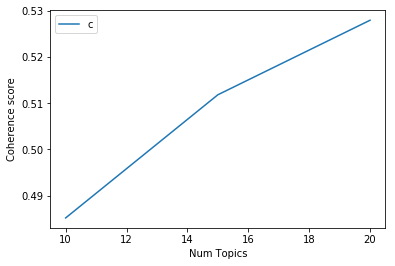

In [39]:
x = lda_params['topics_range']
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Pick the model based on the highest coherence value

In [40]:
# alternatively, pick a number of topics were the score starts to flatten out
num_topics = list(lda_params['topics_range'])[np.argmax(coherence_values)]
optimal_model = model_list[np.argmax(coherence_values)]

In [59]:
optimal_model.save(outdata_path+'lda_model_'+str(num_topics)) 

In [61]:
# optimal_model = LdaMulticore.load(outdata_path+'lda_model_'+str(num_topics)) 

In [41]:
# number of words per topic to display (can be any number within vocabulary size)
num_words = 10
top_topics = optimal_model.top_topics(corpus=bow_corpus, 
                                      texts=data_preprocessed,
                                      coherence=lda_params['coherence'], 
                                      topn=num_words)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: 0.5795.
[([(0.047301374, 'military'),
   (0.033706147, 'defense'),
   (0.032630187, 'war'),
   (0.029952077, 'veterans'),
   (0.020722518, 'iraq'),
   (0.01906118, 'service'),
   (0.018649735, 'force'),
   (0.017238507, 'troop'),
   (0.013840212, 'army'),
   (0.013697415, 'arm')],
  0.7267307947559561),
 ([(0.08447954, 'health'),
   (0.06435564, 'care'),
   (0.023339663, 'insurance'),
   (0.019923273, 'medical'),
   (0.019443458, 'medicare'),
   (0.012354724, 'cost'),
   (0.011429969, 'plan'),
   (0.011342537, 'service'),
   (0.01094931, 'provide'),
   (0.0094103, 'coverage')],
  0.6694707813977734),
 ([(0.042077623, 'budget'),
   (0.026653295, 'billion'),
   (0.025501912, 'spend'),
   (0.025129683, 'year'),
   (0.025065226, 'tax'),
   (0.023456588, 'cut'),
   (0.02057774, 'fund'),
   (0.020295478, 'program'),
   (0.019950278, 'percent'),
   (0.01606157, 'million')],
  0.6500065368897117),
 ([(0.10173203, 'vote'),
   (0.025778078, 'republican'),
   (0.0226123, 

In [42]:
def get_topics_keywords_dict(ldamodel, num_topics):
    topic_dict = {}
    for i in range(num_topics):
        topic_dict[i] = [word[0] for word in ldamodel.show_topic(i)]
    return topic_dict
keywords_dict = get_topics_keywords_dict(optimal_model, num_topics)

### Append primary and secondary topics to the speech file

In [43]:
def append_topic(ldamodel, corpus, speeches, ids, kw_dict):
    # Init output
    speech_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        sorted_topics = sorted(row, key=lambda x: -x[1])
        topic_count = len(sorted_topics)
        
        topic1_num, topic1_contrib = sorted_topics[0]
        topic1_keywords = ','.join(kw_dict[topic1_num])
        
        if topic_count > 1:
            topic2_num, topic2_contrib = sorted_topics[1]
        else:
            topic2_num, topic2_contrib = -1, 0
        
        new_row = [topic_count, int(topic1_num), round(topic1_contrib,2), topic1_keywords, int(topic2_num), round(topic2_contrib,2)]
        speech_topics_df = speech_topics_df.append(pd.Series(new_row), ignore_index=True)

    speech_topics_df = pd.concat([speech_topics_df, pd.Series(ids)], axis=1)
    speech_topics_df.columns = ['Topic_Count', 'Prim_Topic', 'Prim_Topic_Contrib', 'Prim_Topic_Keywords', 'Sec_Topic', 'Sec_Topic_Contrib', 'Speech_id']
    
    return speech_topics_df


all_speeches_topics_df = append_topic(ldamodel=optimal_model, 
                                      corpus=bow_corpus, 
                                      speeches=data_preprocessed, 
                                      ids=main_ids,
                                      kw_dict=keywords_dict)
all_speeches_topics_df.shape

(62716, 7)

In [44]:
all_speeches_topics_df.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,3.0,8.0,0.68,"vote,republican,house,rule,debate,majority,rep...",1.0,0.15,1080099024
1,10.0,10.0,0.61,"american,live,nation,day,world,great,history,a...",5.0,0.12,1080165561
2,7.0,7.0,0.41,"military,defense,war,veterans,iraq,service,for...",3.0,0.33,1090156218
3,7.0,4.0,0.71,"get,think,want,know,come,talk,let,way,see,country",8.0,0.13,1060121740
4,10.0,6.0,0.45,"fund,federal,service,program,provide,project,s...",9.0,0.12,1100177577


In [64]:
all_speeches_topics_df.to_pickle(outdata_path+'speeches_topics_'+str(num_topics))

In [65]:
# all_speeches_topics_df = pd.read_pickle(outdata_path+'speeches_topics_'+str(num_topics))

### Pick one speech per document with the highest score

In [45]:
# Selecting n top speeches per topic
top_speeches = 1
top_speeches_df = pd.DataFrame()

all_speeches_topics_df_grpd = all_speeches_topics_df.groupby('Prim_Topic')

for i, grp in all_speeches_topics_df_grpd:
    top_speeches_df = pd.concat([top_speeches_df, grp.sort_values(by='Prim_Topic_Contrib', ascending=False).head(top_speeches)], axis=0)

top_speeches_df.reset_index(drop=True, inplace=True)

In [46]:
for i in range(top_speeches_df.shape[0]):
    print("Topic number: ", top_speeches_df.Prim_Topic[i])
    print("Topic contribution: {:.2f}".format(top_speeches_df.Prim_Topic_Contrib[i]))
    print("Keywords: \n", top_speeches_df.Prim_Topic_Keywords[i])
    print("Speech: \n", main_data[main_ids.index(top_speeches_df.Speech_id[i])])
    print("-"*50)

Topic number:  0.0
Topic contribution: 0.78
Keywords: 
 trade,american,economic,industry,technology,job,market,foreign,export,world
Speech: 
 Mr. Speaker. CAFTA. the United States Central American Free Trade Agreement. is yet another unfair trade deal that will hurt American workers. CAFTA is the latest unfair trade deal in a decade of failed trade policies. Over the last 12 years. the United States trade deficit has exploded from $39 billion in 1992 to over $618 billion in 2004. If CAFTA becomes effective. the result will be fewer jobs for American workers. CAFTA is modeled on NAFTA. the North American Free Trade Agreement. which had and continues to have a devastating impacton many American workers. When NAFTA was passed in 1994. the United States had a $2 billion trade surplus with.Mexico. In 2004. we had a $45 billion trade deficit in Mexico. That means our trade deficit with Mexico increased by an average of $4.7 billion per year- over the last 10
---------------------------------

### Primary and secondary topic distribution in the speech file

In [47]:
topics_df = pd.DataFrame(index=range(num_topics))
# Number of Documents for Each Topic
prim_topic_counts = all_speeches_topics_df['Prim_Topic'].value_counts().sort_index()
sec_topic_counts = all_speeches_topics_df['Sec_Topic'].value_counts().sort_index()
# Percentage of Documents for Each Topic
prim_topic_share = round(prim_topic_counts/len(main_data), 2)
prim_topic_share.name = 'Prim_Topic_Contr'
sec_topic_share = round(sec_topic_counts/len(main_data), 2)
sec_topic_share.name = 'Sec_Topic_Contr'

In [48]:
topics_df= topics_df.join(prim_topic_counts)\
                    .join(prim_topic_share)\
                    .join(sec_topic_counts)\
                    .join(sec_topic_share)\
                    .join(pd.DataFrame.from_dict(keywords_dict, orient='index'))
topics_df.reset_index(inplace=True)
topics_df.columns = ['Topic_Num', "Prim_Cnt", "Prim_Share", "Sec_Cnt", "Sec_Share"] + ['kw'+str(i) for i in range(num_words)]
topics_df.Prim_Cnt.sum(), topics_df.Prim_Share.sum(), topics_df.Sec_Cnt.sum(), topics_df.Sec_Share.sum()

(62716, 1.01, 62133, 0.9900000000000001)

In [49]:
topics_df.sort_values(by='Prim_Cnt', ascending=False)

,Topic_Num,Prim_Cnt,Prim_Share,Sec_Cnt,Sec_Share,kw0,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9
4,4,11334,0.18,7890,0.13,get,think,want,know,come,talk,let,way,see,country
12,12,6149,0.10,6839,0.11,legislation,congress,issue,require,act,concern,process,believe,use,change
14,14,5670,0.09,3230,0.05,serve,service,community,honor,state,member,award,join,rise,family
9,9,4939,0.08,4639,0.07,gentleman,chairman,thank,yield,committee,want,legislation,distinguish,issue,colleague
10,10,4035,0.06,4791,0.08,american,live,nation,day,world,great,history,americans,country,life
1,1,3553,0.06,3025,0.05,committee,house,report,conference,act,appropriations,section,hear,authorize,year
17,17,3168,0.05,3226,0.05,budget,billion,spend,year,tax,cut,fund,program,percent,million
2,2,2653,0.04,2271,0.04,world,security,government,international,nations,force,policy,foreign,must,administration
6,6,2584,0.04,3332,0.05,fund,federal,service,program,provide,project,state,national,local,million
13,13,2321,0.04,2816,0.04,program,school,education,students,children,provide,high,community,help,college


In [67]:
topics_df.to_pickle(outdata_path+'topics_summary_'+str(num_topics))

In [68]:
# topics_df = pd.read_pickle(outdata_path+'topics_summary_'+str(num_topics))